# Tensor completion (example of minimizing a loss w.r.t. TT-tensor)

[Open](https://colab.research.google.com/github/Bihaqo/t3f/blob/develop/docs/tutorials/tensor_completion.ipynb) **this page in an interactive mode via Google Colaboratory.**

In this example we will see how can we do tensor completion with t3f, i.e. observe a fraction of values in a tensor and recover the rest by assuming that the original tensor has low TT-rank.
Mathematically it means that we have a binary mask $P$ and a ground truth tensor $A$, but we observe only a noisy and sparsified version of $A$: $P \odot (\hat{A})$, where $\odot$ is the elementwise product (applying the binary mask) and $\hat{A} = A + \text{noise}$. In this case our task reduces to the following optimization problem:

$$
\begin{aligned}
& \underset{X}{\text{minimize}} 
& & \|P \odot (X - \hat{A})\|_F^2 \\
& \text{subject to} 
& & \text{tt_rank}(X) \leq r_0
\end{aligned}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Import TF 2.
%tensorflow_version 2.x
import tensorflow as tf

# Fix seed so that the results are reproducable.
tf.random.set_seed(0)
np.random.seed(0)

try:
    import t3f
except ImportError:
    # Install T3F if it's not already installed.
    !git clone https://github.com/Bihaqo/t3f.git
    !cd t3f; pip install .
    import t3f

TensorFlow 2.x selected.


**Generating problem instance**

Lets generate a random matrix $A$, noise, and mask $P$.

In [0]:
shape = (3, 4, 4, 5, 7, 5)
# Generate ground truth tensor A. To make sure that it has low TT-rank,
# let's generate a random tt-rank 5 tensor and apply t3f.full to it to convert to actual tensor.
ground_truth = t3f.full(t3f.random_tensor(shape, tt_rank=5))
# Make a (non trainable) variable out of ground truth. Otherwise, it will be randomly regenerated on each sess.run.
ground_truth = tf.Variable(ground_truth, trainable=False)
noise = 1e-2 * tf.Variable(tf.random.normal(shape), trainable=False)
noisy_ground_truth = ground_truth + noise
# Observe 25% of the tensor values.
sparsity_mask = tf.cast(tf.random.uniform(shape) <= 0.25, tf.float32)
sparsity_mask = tf.Variable(sparsity_mask, trainable=False)
sparse_observation = noisy_ground_truth * sparsity_mask

**Initialize the variable and compute the loss**

In [0]:
observed_total = tf.reduce_sum(sparsity_mask)
total = np.prod(shape)
initialization = t3f.random_tensor(shape, tt_rank=5)
estimated = t3f.get_variable('estimated', initializer=initialization)

SGD optimization
-------------------------
The simplest way to solve the optimization problem is Stochastic Gradient Descent: let TensorFlow differentiate the loss w.r.t. the factors (cores) of the TensorTrain decomposition of the estimated tensor and minimize the loss with your favourite SGD variation.

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

def step():
  with tf.GradientTape() as tape:
    # Loss is MSE between the estimated and ground-truth tensor as computed in the observed cells.
    loss = 1.0 / observed_total * tf.reduce_sum((sparsity_mask * t3f.full(estimated) - sparse_observation)**2)

  gradients = tape.gradient(loss, estimated.tt_cores)
  optimizer.apply_gradients(zip(gradients, estimated.tt_cores))

  # Test loss is MSE between the estimated tensor and full (and not noisy) ground-truth tensor A.
  test_loss = 1.0 / total * tf.reduce_sum((t3f.full(estimated) - ground_truth)**2)
  return loss, test_loss

In [7]:
train_loss_hist = []
test_loss_hist = []
for i in range(5000):
  tr_loss_v, test_loss_v = step()
  tr_loss_v, test_loss_v = tr_loss_v.numpy(), test_loss_v.numpy()
  train_loss_hist.append(tr_loss_v)
  test_loss_hist.append(test_loss_v)
  if i % 1000 == 0:
    print(i, tr_loss_v, test_loss_v)

0 1.768507 1.6856995
1000 0.0011041266 0.001477238
2000 9.759675e-05 3.4615714e-05
3000 8.749525e-05 2.0825255e-05
4000 9.1277245e-05 2.188003e-05
5000 9.666496e-05 3.5304438e-05
6000 8.7534434e-05 2.1069698e-05
7000 8.753277e-05 2.1103975e-05
8000 9.058935e-05 2.6075113e-05
9000 8.8796776e-05 2.2456348e-05


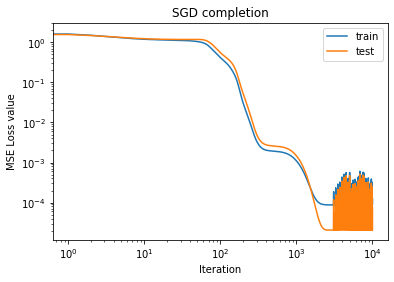

In [8]:
plt.loglog(train_loss_hist, label='train')
plt.loglog(test_loss_hist, label='test')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss value')
plt.title('SGD completion')
plt.legend()


Speeding it up
--------------------
The simple solution we have so far assumes that loss is computed by materializing the full estimated tensor and then zeroing out unobserved elements. If the tensors are really large and the fraction of observerd values is small (e.g. less than 1%), it may be much more efficient to directly work only with the observed elements.

In [0]:
shape = (10, 10, 10, 10, 10, 10, 10)

total_observed = np.prod(shape)
# Since now the tensor is too large to work with explicitly,
# we don't want to generate binary mask,
# but we would rather generate indecies of observed cells.

ratio = 0.001

# Let us simply randomly pick some indecies (it may happen
# that we will get duplicates but probability of that
# is 10^(-14) so lets not bother for now).

num_observed = int(ratio * total_observed)
observation_idx = np.random.randint(0, 10, size=(num_observed, len(shape)))
# and let us generate some values of the tensor to be approximated
observations = np.random.randn(num_observed)


In [0]:
# Our strategy is to feed the observation_idx
# into the tensor in the Tensor Train format and compute MSE between
# the obtained values and the desired values

In [0]:
initialization = t3f.random_tensor(shape, tt_rank=16)
estimated = t3f.get_variable('estimated', initializer=initialization)

In [0]:
# To collect the values of a TT tensor (withour forming the full tensor)
# we use the function t3f.gather_nd

In [0]:
def loss():
  estimated_vals = t3f.gather_nd(estimated, observation_idx)
  return tf.reduce_mean((estimated_vals - observations) ** 2)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
def step():
  with tf.GradientTape() as tape:
    loss_value = loss()
  gradients = tape.gradient(loss_value, estimated.tt_cores)
  optimizer.apply_gradients(zip(gradients, estimated.tt_cores))
  return loss_value

#### Compiling the function to additionally speed things up


In [0]:
# In TF eager mode you're supposed to first implement and debug
# a function, and then compile it to make it faster.
faster_step = tf.function(step)

In [16]:
loss_hist = []
for i in range(2000):
    loss_v = faster_step().numpy()
    loss_hist.append(loss_v)
    if i % 100 == 0:
        print(i, loss_v)

0 2.513642
100 0.09261158
200 0.016660467
300 0.0062909224
400 0.0030982601
500 0.0018596936
600 0.0012290174
700 0.00086869544
800 0.00065623457
900 0.00052747165
1000 0.00044029654
1100 0.00038606362
1200 0.00033268757
1300 0.0002910529
1400 0.00028836995
1500 0.00023541097
1600 0.00022489333
1700 0.00022316887
1800 0.00039261775
1900 0.0003216249


No handles with labels found to put in legend.


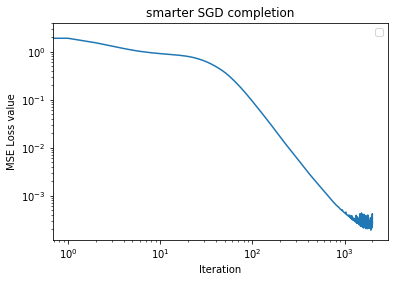

In [17]:
plt.loglog(loss_hist)
plt.xlabel('Iteration')
plt.ylabel('MSE Loss value')
plt.title('smarter SGD completion')
plt.legend()

In [18]:
print(t3f.gather_nd(estimated, observation_idx))

tf.Tensor(
[-0.12139133 -1.3777294  -0.5469675  ... -0.00776806  0.23622975
  0.7571926 ], shape=(10000,), dtype=float32)


In [19]:
print(observations)

[-1.27225139e-01 -1.37794858e+00 -5.42469328e-01 ... -1.30643336e-03
  2.35629296e-01  7.53320726e-01]
